In [44]:
# Include relevant packages
# Reduce the minimum methods in the notebook
# Put everything in pyACC

import sys
sys.path.append('../')

from pyACC.cosmology.distances import hubble_function, CosmologicalDistances, LambdaCDMCosmology

from pyACC.cosmology.distances_func import distance_modulus_from_redshift

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

In [46]:
# Theory

# Define your functions to get cosmological distances from a list of redshifts and different
# cosmological models
# 1. LCDM
# 2. wCDM
# 3. your choice

In [47]:
print('LambdaCDM cosmo is ', LambdaCDMCosmology())

LambdaCDM cosmo is  {'H0': 67, 'Om_m': 0.319, 'Om_lambda': 0.681, 'Om_rad': 0.0, 'Om_nu': 0.0, 'Om_k': 0.0, 'w0': -1.0, 'wa': 0.0}


In [48]:
cd = CosmologicalDistances(hubble_function)

In [49]:
redshift_list = np.linspace(0.01, 2.2, 100)

mu = cd.distance_modulus_from_redshift(redshift_list)
luminosity_distance = cd.luminosity_distance(redshift_list)
hubble_distance = cd.hubble_distance(redshift_list)
transverse_comoving_distance = cd.transverse_comoving_distance(redshift_list)
isotropic_volume_distance = cd.isotropic_volume_distance(redshift_list)

In [50]:
# Dataset

# Read the datasets, and plot the data against Planck 2018 LCDM cosmology

In [51]:
print("Read SN data")
SN_data = pd.read_csv("./data/SNIa_data.txt", sep=" ", header=None, names=["Redshift", "Distance"])
SN_covariance = np.genfromtxt("./data/SNIa_covariance.txt")
SN_data["Error"] = np.sqrt(np.diag(SN_covariance))
SN_data["Kind"] = "\mu"
SN_data["Name"] = "Pantheon+"


Read SN data


In [52]:
SN_data

,Redshift,Distance,Error,Kind,Name
0,0.01012,13.909104,0.199394,\mu,Pantheon+
1,0.01038,14.046894,0.205908,\mu,Pantheon+
2,0.01043,13.927942,0.201482,\mu,Pantheon+
3,0.01082,14.008714,0.185679,\mu,Pantheon+
4,0.01209,13.976718,0.192585,\mu,Pantheon+
...,...,...,...,...,...
1002,1.55000,26.006720,0.194426,\mu,Pantheon+
1003,1.70000,26.058309,0.289536,\mu,Pantheon+
1004,1.80000,26.201409,0.197367,\mu,Pantheon+
1005,1.91400,26.160282,0.262894,\mu,Pantheon+


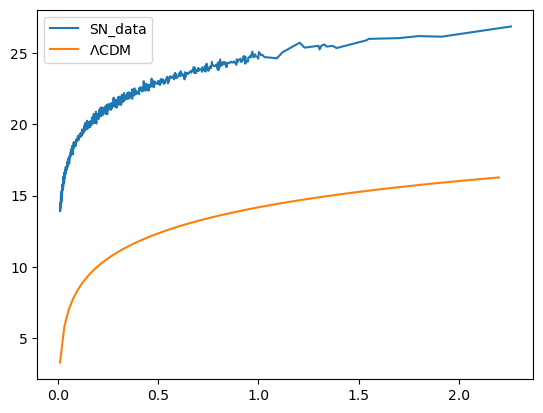

In [53]:
plt.plot(SN_data['Redshift'], SN_data['Distance'], label='SN_data')
plt.plot(redshift_list, mu, label=r'$\Lambda$CDM' )
plt.legend()

In [54]:
print("Read BAO data")
BAO_data = pd.read_csv("./data/BAO_data.txt")
BAO_covariance = pd.read_csv("./data/BAO_covariance.txt", header=None).replace(np.NaN, 0).to_numpy()

# Sound horizon from Planck 2018, Table 2, TT,TE,EE+lowE
rd = 147.06

Read BAO data


In [55]:
BAO_data

,Redshift,Distance,Error,Kind,Name
0,0.15,4.47,0.17,D_V/r_d,MGS
1,0.38,10.23,0.17,D_M/r_d,BOSS DR12
2,0.38,25.00,0.76,D_H/r_d,BOSS DR12
3,0.51,13.36,0.21,D_M/r_d,BOSS DR12
4,0.51,22.33,0.58,D_H/r_d,BOSS DR12
5,0.70,17.86,0.33,D_M/r_d,eBOSS LRG
6,0.70,19.33,0.53,D_H/r_d,eBOSS LRG
7,0.85,18.33,0.06,D_V/r_d,eBOSS ELG
8,1.48,30.69,0.80,D_M/r_d,eBOSS Quasar
9,1.48,13.26,0.55,D_H/r_d,eBOSS Quasar


Text(0.5, 1.0, 'SNIa - Distance Modulus')

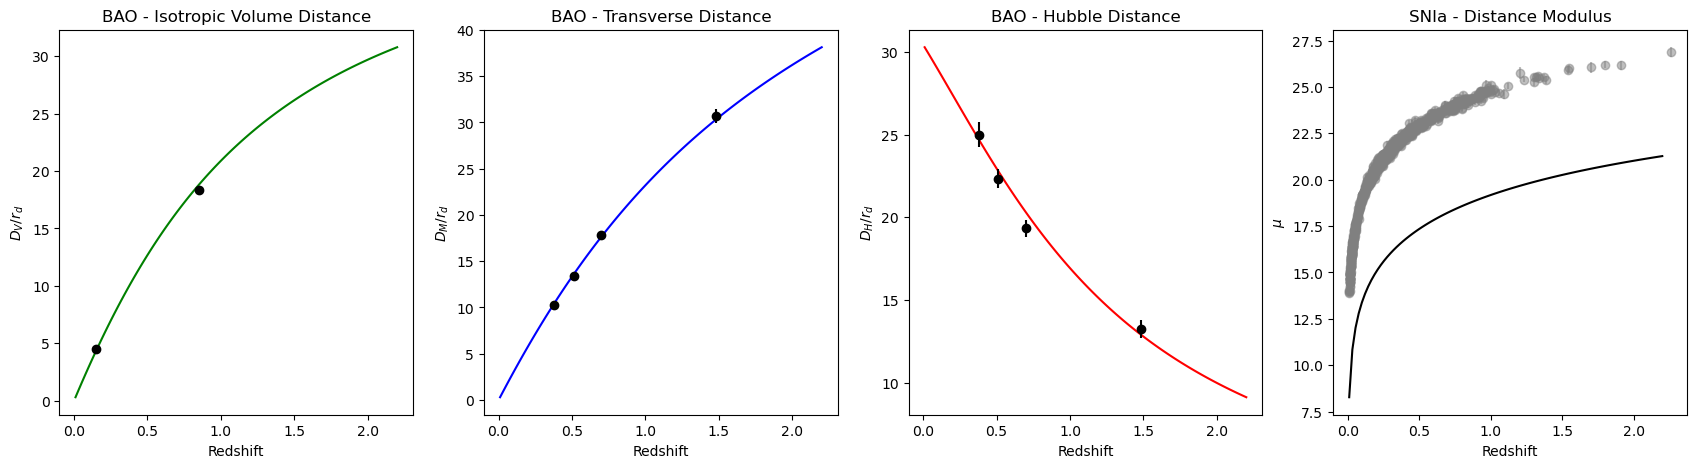

In [56]:
distance_type = pd.unique(BAO_data["Kind"])                 ## list of unique distance types

fig, ax = plt.subplots(1, 4, figsize=(21, 5))
ax[0].plot(redshift_list, isotropic_volume_distance/rd, color="g")
ax[1].plot(redshift_list, transverse_comoving_distance/rd, color="b")
ax[2].plot(redshift_list, hubble_distance/rd, color="r")
ax[3].plot(redshift_list, 5*np.log10(luminosity_distance), color="k")

## for each distance type plot, add errorbars and axis labels
for i,dt in enumerate(distance_type):
    data = BAO_data[BAO_data["Kind"] == dt]
    ax[i].errorbar(data["Redshift"], data["Distance"], yerr=data["Error"], fmt='o', color="k")
    ax[i].set_xlabel("Redshift")
    ax[i].set_ylabel(r"$%s$"%dt)

ax[3].errorbar(SN_data["Redshift"], SN_data["Distance"], yerr=SN_data["Error"], fmt='o', color="0.5", alpha=0.5)
ax[3].set_xlabel("Redshift")
ax[3].set_ylabel(r"$\mu$")

ax[0].set_title("BAO - Isotropic Volume Distance")
ax[1].set_title("BAO - Transverse Distance")
ax[2].set_title("BAO - Hubble Distance")
ax[3].set_title("SNIa - Distance Modulus")


### Pantheon+ likelihood

The likelihood for sn1a can be marginalized analitically on the intrinsic luminosity of the stars. See Marco 2022 'Cosmic Structures' class. 

$\mathcal{L}_m = \int \exp{[-\frac{1}{2}(d-\mu+\alpha\vec{1})^T\Sigma^{-1}(d-\mu+\alpha\vec{1})]d\alpha}$

The result is the following (after some matrix algebra and integrations, see matrix cookbook)

$\log{\mathcal{L}_m} = -\frac{1}{2}(d-\mu)^T\Sigma^{-1}(d-\mu)+\frac{1}{2}\frac
{[(d-\mu)^T\Sigma^{-1}\vec{1}]^2}{\vec{1}^T\Sigma^{-1}\vec{1}}$

In [58]:
# Likelihood

# Define the likelihood function for the data

mu_teo = distance_modulus_from_redshift(SN_data['Redshift'])
SN_inv_cov = np.linalg.inv(SN_covariance)
n = len(SN_data['Distance'])

def logL_sn(pars):
    w=pars[0]
    Om_m=pars[1]
    x = SN_data['Distance']-distance_modulus_from_redshift(SN_data['Redshift'], Om_m=Om_m, w0=w)
    return -0.5*(-np.linalg.multi_dot([x,SN_inv_cov,x])+(np.linalg.multi_dot([x,SN_inv_cov,np.ones(n)]))**2/np.linalg.multi_dot([np.ones(n),SN_inv_cov,np.ones(n)]))

In [59]:
# Likelihood maximization
# Use scipy.optimize to maximize the likelihood function for different cosmological models
# Get best-fit parameters and plot the best-fit model against the data and Planck 2018 cosmology
in_guess = [-1,0.3]
max_l=minimize(logL_sn,in_guess, bounds=[(-1.5,0.5),(0.1,1)])

In [60]:
print('maximum likelihood in', max_l.x)

maximum likelihood in [-1.02091276  0.29997543]


### BaoLikelihood

In [ ]:
def logL_bao(pars):
    w=pars[0]
    Om_m=pars[1]
    return 0

In [61]:
# Model selection
# Test different models using the likelihood ratio test

In [62]:
# Sample the posterior

# Define the priors for the cosmological parameters
# Sample the posterior using MCMC in pyACC
# Clean the chains and plot the results

In [63]:
# Analyze the results

# Get relevant quantities from marginalized posteriors
# Check consistency with maximum likelihood results
# Check consistency with Planck 2018 results
# Plot the chains
# Plot the posterior distributions

In [64]:
# Summarize your results

# Write a report with your results
# put emphasis on the numerical part, specyfing the numerical techniques used.
# Share your results in form of chains